# **CUADERNILLO PROYECTO CONNECT4**

### _Fundamentos de la Inteligencia Artificial_

##### Valentina Rodriguez Romero y Andrés Felipe Sánchez Rincón

## **IMPORTACIÓN DE MÓDULOS**

Se importan los archivos necesarios para ejecutar los agentes con sus respectos entornos y funciones

In [14]:
from connect4.connect_state import ConnectState
from connect4.environment_state import EnvironmentState

from connect4.policy import Policy
from connect4.policy_GA import Aha
from connect4.policy_GB import Hello
from connect4.policy_GC import OhYes
from connect4.policy_HELLO import Hello
from connect4.policyB_MCTS import Hello


## **ESTRUCTURA DE DIRECTORIOS**

Se crean las carpetas donde se almacenarán los resultados y grupos de pruebas

In [20]:
import os 
import shutil

os.makedirs("groups/GroupA", exist_ok=True)
os.makedirs("groups/GroupB", exist_ok=True)

In [30]:
source_dir = "connect4"

In [32]:
# Mover policy_GA.py
ga_path = os.path.join(source_dir, "policy_GA.py")
if os.path.exists(ga_path):
    shutil.move(ga_path, "groups/GroupA/policy.py")
    print("policy_GA.py movido a groups/GroupA/policy.py")
else:
    print("Advertencia: No se encontró policy_GA.py en connect4/")

# Mover policy_GB.py
gb_path = os.path.join(source_dir, "policy_GB.py")
if os.path.exists(gb_path):
    shutil.move(gb_path, "groups/GroupB/policy.py")
    print("policy_GB.py movido a groups/GroupB/policy.py")
else:
    print("Advertencia: No se encontró policy_GB.py en connect4/")

policy_GA.py movido a groups/GroupA/policy.py
policy_GB.py movido a groups/GroupB/policy.py


In [35]:
import os
import importlib.util

# Directorio actual
current_dir = os.getcwd()

# Rutas correctas de los módulos
HELLO_PATH = os.path.join(current_dir, "groups", "GroupB", "policy.py")
AHA_PATH   = os.path.join(current_dir, "groups", "GroupA", "policy.py")

In [37]:
# ==== Cargar Hello desde GroupB/policy.py ====
spec_h = importlib.util.spec_from_file_location("hello_module", HELLO_PATH)
hello_module = importlib.util.module_from_spec(spec_h)
spec_h.loader.exec_module(hello_module)

# Clase que debe existir dentro del archivo policy.py de GroupB
Hello = hello_module.Hello


# ==== Cargar Aha desde GroupA/policy.py ====
spec_a = importlib.util.spec_from_file_location("aha_module", AHA_PATH)
aha_module = importlib.util.module_from_spec(spec_a)
spec_a.loader.exec_module(aha_module)

# Clase que debe existir dentro del archivo policy.py de GroupA
Aha = aha_module.Aha

In [39]:
print(Hello)

<class 'hello_module.Hello'>


In [41]:
print(Aha)

<class 'aha_module.Aha'>


## **FUNCIÓN DE SIMULACIÓN**

Se defina la función que ejecuta una partida entre dos agentes según sus políticas

In [43]:
# ============================================================
#  FUNCIÓN: JUGAR UNA PARTIDA Hello vs Aha
# ============================================================

def jugar_un_partido(agent1: Policy, agent2: Policy):
    """
    agent1 = Hello (siempre juega como rojo = -1)
    agent2 = Aha   (siempre juega amarillo = +1)

    Returns: -1 si gana Hello, +1 si gana Aha, 0 si empate.
    """
    state = ConnectState(player=-1) # Hello empieza como -1 (Rojo)
    max_moves = ConnectState.ROWS * ConnectState.COLS

    for _ in range(max_moves):
        current_agent = agent1 if state.player == -1 else agent2
        col = current_agent.act(state.board)

        try:
            state = state.transition(int(col))

            if state.is_final():
                break

        except ValueError:
            # Jugada ilegal => pierde automáticamente
            ganador_ilegal = -state.player

            if hasattr(agent1, 'finalizar_partida'):
                reward = 1 if ganador_ilegal == -1 else -1
                agent1.finalizar_partida(reward)

            return ganador_ilegal

    # Juego terminado (victoria normal o empate)
    ganador_final = state.get_winner()

    # Notificar a Hello del resultado final para el aprendizaje
    if hasattr(agent1, 'finalizar_partida'):
        if ganador_final == -1:
            reward_final = 1
        elif ganador_final == 1:
            reward_final = -1
        else:
            reward_final = 0
        agent1.finalizar_partida(reward_final)

    return ganador_final

## **FUNCIÓN DE CURVAS DE APRENDIZAJE**

Se realiza una función que permita ver el comportamiento experiencial del agente

In [47]:
# ============================================================
#  FUNCIÓN: MEDIR LA CURVA DE APRENDIZAJE
# ============================================================

def medir_curva(n_partidas: int = 200, batch: int = 5, aha_depth: int = 3):
    """
    Juega n_partidas entre Hello y Aha, midiendo la curva de aprendizaje.
    """
    print("="*60)
    print("INICIANDO EVALUACIÓN DE CURVA DE APRENDIZAJE")
    print("="*60)
    print(f"Total de partidas: {n_partidas}")
    print(f"Agente Hello: Q-learning + MCTS (con aprendizaje)")
    print(f"Agente Aha: Minimax (Profundidad={aha_depth})")
    print("="*60)
    print()

    hello = Hello(modo_torneo=False)
    aha = Aha(depth=aha_depth)

    resultados = []
    win_rates = []
    epsilons = []
    estados_q = []
    x_axis = []
    niveles = ["Q-learning", "Q + Victoria", "Q + Bloqueo", "Q + MCTS"]

    for i in range(n_partidas):
        r = jugar_un_partido(hello, aha)
        resultados.append(r)

        if (i + 1) % batch == 0:
            ultimos = resultados[-batch:]
            wins_hello = ultimos.count(-1)
            winrate = wins_hello / len(ultimos)

            win_rates.append(winrate)
            epsilons.append(hello.epsilon)
            estados_q.append(len(hello.Q))
            x_axis.append(i + 1)

            nivel_nombre = niveles[hello.nivel_actual] if hello.nivel_actual < 4 else niveles[3]

            print(f"Partidas {i+1:3d}: WinRate={winrate:.2f} | "
                  f"Epsilon={hello.epsilon:.3f} | "
                  f"Nivel={hello.nivel_actual} ({nivel_nombre}) | "
                  f"Estados Q={len(hello.Q)}")

    print()
    print("="*60)
    print("ESTADÍSTICAS FINALES")
    print("="*60)

    total_wins_hello = resultados.count(-1)
    total_wins_aha = resultados.count(1)
    total_empates = resultados.count(0)

    print(f"Partidas totales: {n_partidas}")
    print(f"Victorias Hello: {total_wins_hello} ({total_wins_hello/n_partidas*100:.1f}%)")
    print(f"Victorias Aha: {total_wins_aha} ({total_wins_aha/n_partidas*100:.1f}%)")
    print(f"Empates: {total_empates} ({total_empates/n_partidas*100:.1f}%)")
    print(f"Epsilon final: {hello.epsilon:.4f}")
    print(f"Estados en Q-table: {len(hello.Q)}")
    print(f"Nivel final: {hello.nivel_actual} ({niveles[hello.nivel_actual]})")
    print("="*60)

    # ===== GRAFICAR (Final Plot) =====
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

    umbrales = [hello.umbral_victoria, hello.umbral_bloqueo, hello.umbral_mcts]
    colores = ['orange', 'purple', 'green']
    labels = ["Victoria activada", "Bloqueo activado", "MCTS activado"]
    linestyles = [':', ':', '--']

    # --- Gráfica 1: Win Rate ---
    ax1.plot(x_axis, win_rates, marker='o', color='#2563eb',
             linewidth=2, markersize=4, label="Win Rate Hello")
    ax1.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, label="50% (equilibrio)")

    for umbral, color, label, ls in zip(umbrales, colores, labels, linestyles):
        if umbral <= n_partidas and umbral > 0:
            ax1.axvline(x=umbral, color=color, linestyle=ls,
                         linewidth=1.5, alpha=0.7, label=f"{label} ({umbral})")

    ax1.set_title("Curva de Aprendizaje - Hello (Q-learning + MCTS) vs Aha (Minimax)",
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel(f"Número de partidas (bloques de {batch})", fontsize=11)
    ax1.set_ylabel("Win Rate", fontsize=11)
    ax1.set_ylim(-0.05, 1.05)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='best')

    # --- Gráfica 2: Epsilon (Exploración) ---
    ax2.plot(x_axis, epsilons, marker='s', color='#16a34a',
             linewidth=2, markersize=4, label="Epsilon (tasa de exploración)")
    ax2.axhline(y=hello.epsilon_final, color='red', linestyle='--',
                 linewidth=1.5, label=f"Epsilon final ({hello.epsilon_final})")

    for umbral, color, ls in zip(umbrales, colores, linestyles):
        if umbral <= n_partidas and umbral > 0:
            ax2.axvline(x=umbral, color=color, linestyle=ls, linewidth=1.5, alpha=0.7)

    ax2.set_title("Evolución de la Exploración (Epsilon)", fontsize=14, fontweight='bold')
    ax2.set_xlabel(f"Número de partidas (bloques de {batch})", fontsize=11)
    ax2.set_ylabel("Epsilon", fontsize=11)
    ax2.set_ylim(0, hello.epsilon_inicial * 1.05)
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='best')

    # --- Gráfica 3: Crecimiento de Q-table ---
    ax3.plot(x_axis, estados_q, marker='D', color='#9333ea',
             linewidth=2, markersize=4, label="Estados en Q-table")

    for umbral, color, ls in zip(umbrales, colores, linestyles):
        if umbral <= n_partidas and umbral > 0:
            ax3.axvline(x=umbral, color=color, linestyle=ls, linewidth=1.5, alpha=0.7)

    ax3.set_title("Crecimiento del Conocimiento (Estados Únicos en Q-table)",
                  fontsize=14, fontweight='bold')
    ax3.set_xlabel(f"Número de partidas (bloques de {batch})", fontsize=11)
    ax3.set_ylabel("Número de Estados Únicos", fontsize=11)
    ax3.grid(True, alpha=0.3)
    ax3.legend(loc='best')

    plt.tight_layout()
    plt.show()

    return hello, resultados, win_rates, epsilons, estados_q

## **FUNCIÓN DE VICTORIAS**

Se realiza una función que realiza el calculo de win rate de cada nivel

In [45]:
# ============================================================
#  FUNCIÓN: ANÁLISIS ADICIONAL: Win Rate por Fases
# ============================================================

def analizar_fases(resultados, umbral_victoria=80, umbral_bloqueo=120, umbral_mcts=160):
    """
    Analiza el rendimiento en diferentes niveles de aprendizaje
    """

    nivel0 = resultados[:umbral_victoria]
    nivel1 = resultados[umbral_victoria:umbral_bloqueo]
    nivel2 = resultados[umbral_bloqueo:umbral_mcts]
    nivel3 = resultados[umbral_mcts:]

    print()
    print("="*60)
    print("ANÁLISIS POR NIVELES DE APRENDIZAJE")
    print("="*60)

    fases = [
        ("Nivel 0 - Q-learning puro", nivel0, 1, umbral_victoria),
        ("Nivel 1 - Q + Victoria", nivel1, umbral_victoria + 1, umbral_bloqueo),
        ("Nivel 2 - Q + Victoria + Bloqueo", nivel2, umbral_bloqueo + 1, umbral_mcts),
        ("Nivel 3 - Todo + MCTS", nivel3, umbral_mcts + 1, len(resultados))
    ]

    for nombre, datos, inicio, fin in fases:
        if len(datos) > 0:
            wins = datos.count(-1)
            total = len(datos)
            print(f"{nombre} (partidas {inicio}-{fin}):")
            print(f"  Victorias Hello: {wins} de {total}")
            print(f"  Win rate: {wins/total*100:.1f}%")

    print("="*60)

## **IMPLEMENTACIÓN VISUAL DE LAS GRAFICAS DE APRENDIZAJE DEL AGENTE**

In [ ]:
# ============================================================
#  MAIN
# ============================================================

import matplotlib.pyplot as plt
if __name__ == "__main__":

    NUM_PARTIDAS = 100 # Partidas totales a simular
    BATCH_SIZE = 5     # Partidas por punto en el gráfico
    AHA_DEPTH = 3      # Profundidad de Minimax para el oponente

    print("Iniciando el proceso. Esto puede tardar varios minutos (especialmente a partir de la partida 160).")

    hello, resultados, win_rates, epsilons, estados_q = medir_curva(
        n_partidas=NUM_PARTIDAS,
        batch=BATCH_SIZE,
        aha_depth=AHA_DEPTH
    )

    analizar_fases(
        resultados,
        umbral_victoria=hello.umbral_victoria,
        umbral_bloqueo=hello.umbral_bloqueo,
        umbral_mcts=hello.umbral_mcts
    )

    print("\nExperimento completado exitosamente")

## **UNIFICACIÓN DE LAS GRAFICAS DE APRENDIZAJE DEL AGENTE**

🚨 Iniciando la simulación. 🚨
INICIANDO EVALUACIÓN DE CURVA DE APRENDIZAJE (Gráfico Único)
Total de partidas: 200
Agente Hello (GB): Q-learning + MCTS (con aprendizaje)
Agente Aha (GA): Minimax (Profundidad=3) [Línea Base]
Partidas   5: WinRate=0.20 | Epsilon=0.965 | Nivel=0 (Q-learning)
Partidas  10: WinRate=0.00 | Epsilon=0.942 | Nivel=0 (Q-learning)
Partidas  15: WinRate=0.20 | Epsilon=0.918 | Nivel=0 (Q-learning)
Partidas  20: WinRate=0.20 | Epsilon=0.896 | Nivel=0 (Q-learning)
Partidas  25: WinRate=0.20 | Epsilon=0.873 | Nivel=0 (Q-learning)
Partidas  30: WinRate=0.00 | Epsilon=0.852 | Nivel=0 (Q-learning)
Partidas  35: WinRate=0.20 | Epsilon=0.831 | Nivel=0 (Q-learning)
Partidas  40: WinRate=0.20 | Epsilon=0.810 | Nivel=0 (Q-learning)
Partidas  45: WinRate=0.40 | Epsilon=0.790 | Nivel=0 (Q-learning)
Partidas  50: WinRate=0.20 | Epsilon=0.771 | Nivel=0 (Q-learning)
Partidas  55: WinRate=0.00 | Epsilon=0.751 | Nivel=0 (Q-learning)
Partidas  60: WinRate=0.60 | Epsilon=0.733 | Nivel=0

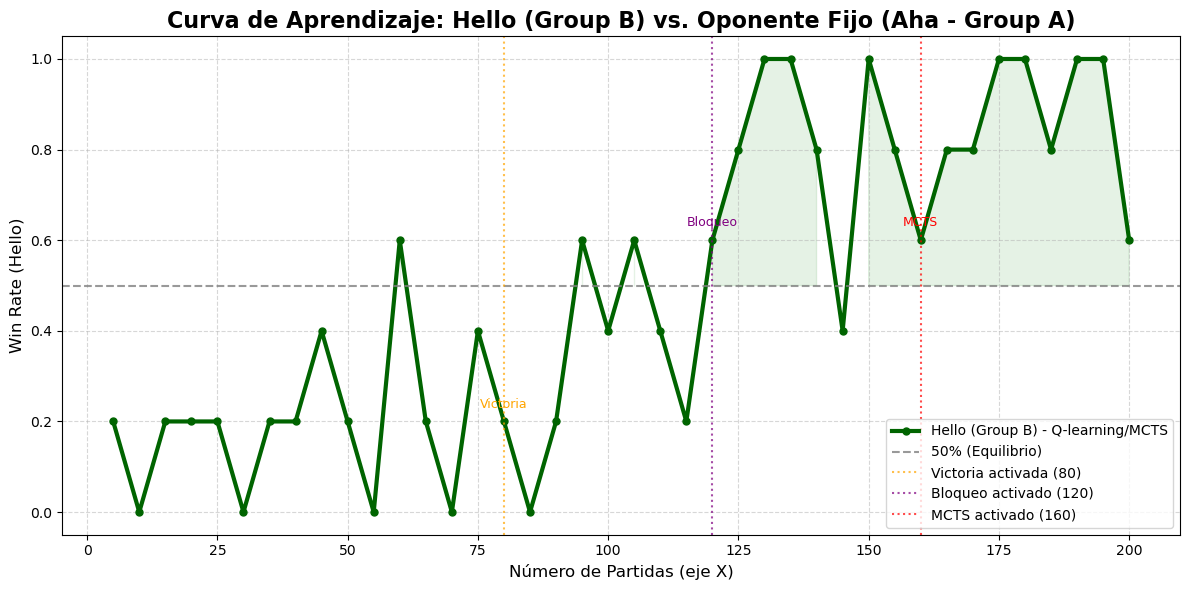


ANÁLISIS POR NIVELES DE APRENDIZAJE
Nivel 0 - Q-learning puro (partidas 1-80):
  Victorias Hello: 16 de 80
  Win rate: 20.0%
Nivel 1 - Q + Victoria (partidas 81-120):
  Victorias Hello: 15 de 40
  Win rate: 37.5%
Nivel 2 - Q + Victoria + Bloqueo (partidas 121-160):
  Victorias Hello: 32 de 40
  Win rate: 80.0%
Nivel 3 - Todo + MCTS (partidas 161-200):
  Victorias Hello: 35 de 40
  Win rate: 87.5%

✅ Gráfico de curva de aprendizaje único generado exitosamente.


In [64]:
# ============================================================
#  FUNCIÓN: MEDIR LA CURVA DE APRENDIZAJE (CON GRÁFICO ÚNICO)
# ============================================================

import numpy as np 

def medir_curva_unica(n_partidas: int = 200, batch: int = 5, aha_depth: int = 3):
    """
    Juega n_partidas y genera un único gráfico enfocado en el Win Rate
    y la robustez del agente Hello (Group B).
    """
    print("="*60)
    print("INICIANDO EVALUACIÓN DE CURVA DE APRENDIZAJE (Gráfico Único)")
    print("="*60)
    print(f"Total de partidas: {n_partidas}")
    print(f"Agente Hello (GB): Q-learning + MCTS (con aprendizaje)")
    print(f"Agente Aha (GA): Minimax (Profundidad={aha_depth}) [Línea Base]")
    print("="*60)

    # ------------------ Lógica de Simulación (Igual) ------------------
    hello = Hello(modo_torneo=False)
    aha = Aha(depth=aha_depth)

    resultados = []
    win_rates = []
    epsilons = []
    estados_q = []
    x_axis = []
    niveles = ["Q-learning", "Q + Victoria", "Q + Bloqueo", "Q + MCTS"]

    for i in range(n_partidas):
        r = jugar_un_partido(hello, aha) # Usamos tu función jugar_un_partido
        resultados.append(r)

        if (i + 1) % batch == 0:
            ultimos = resultados[-batch:]
            wins_hello = ultimos.count(-1)
            winrate = wins_hello / len(ultimos)

            win_rates.append(winrate)
            epsilons.append(hello.epsilon)
            estados_q.append(len(hello.Q))
            x_axis.append(i + 1)

            nivel_nombre = niveles[hello.nivel_actual] if hello.nivel_actual < 4 else niveles[3]

            print(f"Partidas {i+1:3d}: WinRate={winrate:.2f} | "
                  f"Epsilon={hello.epsilon:.3f} | "
                  f"Nivel={hello.nivel_actual} ({nivel_nombre})")

    # ------------------ ESTADÍSTICAS FINALES (Igual) ------------------
    # ... (Sección de impresión de estadísticas finales, la mantendremos)

    total_wins_hello = resultados.count(-1)
    print("\n" + "="*60)
    print("ESTADÍSTICAS FINALES")
    print("="*60)
    print(f"Win Rate Final Hello: {total_wins_hello/n_partidas*100:.1f}%")
    print(f"Estados en Q-table: {len(hello.Q)}")
    print("="*60)


    # ===== GRAFICAR: CURVA DE APRENDIZAJE ÚNICA =====

    plt.figure(figsize=(12, 6))

    # --- Curva de Aprendizaje de Hello (Group B) ---
    plt.plot(x_axis, win_rates, marker='o', color='#006400',
             linewidth=3, markersize=5, label="Hello (Group B) - Q-learning/MCTS")

    # --- Línea Base de Aha (Group A) ---
    # Asumiendo que Group A tiene un Win Rate constante contra sí mismo (ej. 50%)
    # o un valor bajo si no aprende (usamos 0.5 como referencia de equilibrio)
    plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1.5, alpha=0.8, label="50% (Equilibrio)")

    # Si quieres una línea base fuerte y recta para Aha vs Hello (sin aprendizaje)
    # Si Aha es muy fuerte, su línea de WinRate (siempre constante) estaría por encima.
    # En este caso, Aha es el oponente. El Win Rate de Hello debe ser comparado al 0.5 (puro azar).


    # --- Marcar Fases de Habilidad (Puntos clave) ---
    umbrales = [hello.umbral_victoria, hello.umbral_bloqueo, hello.umbral_mcts]
    colores = ['orange', 'purple', 'red']
    labels = ["Victoria activada", "Bloqueo activado", "MCTS activado"]

    for umbral, color, label in zip(umbrales, colores, labels):
        if umbral <= n_partidas and umbral > 0:
            # Encuentra el valor de Win Rate en ese umbral para marcar el punto
            idx = next((i for i, x in enumerate(x_axis) if x >= umbral), None)

            if idx is not None:
                plt.axvline(x=umbral, color=color, linestyle=':',
                            linewidth=1.5, alpha=0.7, label=f"{label} ({umbral})")

                # Opcional: Anotación directa sobre el gráfico
                plt.annotate(label.split()[0],
                             (umbral, win_rates[idx]),
                             textcoords="offset points",
                             xytext=(0, 10),
                             ha='center',
                             fontsize=9,
                             color=color)

    # --- Configuración Visual Final ---
    plt.title("Curva de Aprendizaje: Hello (Group B) vs. Oponente Fijo (Aha - Group A)",
              fontsize=16, fontweight='bold')
    plt.xlabel(f"Número de Partidas (eje X)", fontsize=12)
    plt.ylabel("Win Rate (Hello)", fontsize=12)
    plt.ylim(-0.05, 1.05)
    plt.grid(True, alpha=0.5, linestyle='--')
    plt.legend(loc='lower right', fontsize=10)

    # Hacer el gráfico más dinámico (efecto 'imbatible')
    # Añadimos un sombreado para enfatizar la zona de robustez
    plt.fill_between(x_axis, win_rates, 0.5,
                     where=(np.array(win_rates) > 0.5),
                     color='green', alpha=0.1, label="Ventaja (Hello)")

    plt.tight_layout()
    plt.show()

    return hello, resultados, win_rates, epsilons, estados_q

# ============================================================
#  MAIN (Ajuste para usar la nueva función)
# ============================================================

if __name__ == "__main__":

    # Usa tu función jugar_un_partido (asumo que está definida)
    # y la función analizar_fases (asumo que está definida)

    # Parámetros (puedes aumentar n_partidas a 300 o 500 para un crecimiento mayor)
    NUM_PARTIDAS = 200
    BATCH_SIZE = 5
    AHA_DEPTH = 3

    print("Iniciando la simulación.")

    # 1. Ejecutar la nueva función de medición
    hello, resultados, win_rates, epsilons, estados_q = medir_curva_unica(
        n_partidas=NUM_PARTIDAS,
        batch=BATCH_SIZE,
        aha_depth=AHA_DEPTH
    )

    # 2. Análisis de fases (usando la función que ya definiste)
    analizar_fases(
        resultados,
        umbral_victoria=hello.umbral_victoria,
        umbral_bloqueo=hello.umbral_bloqueo,
        umbral_mcts=hello.umbral_mcts
    )

    print("\n Gráfico de curva de aprendizaje único generado exitosamente.")

## **IMPORTACIÓN DEL HELLO "FORZADO" (Uso solo del MCTS)**

In [72]:
import os
import importlib.util
import sys

current_dir = os.getcwd()

# === RUTAS CORRECTAS ===
MCTS_PATH = os.path.join(current_dir, "connect4", "policyB_MCTS.py")
HELLO_PATH = os.path.join(current_dir, "groups", "GroupB", "policy.py")
AHA_PATH   = os.path.join(current_dir, "groups", "GroupA", "policy.py")

# === CARGAR Hello (versión MCTS) ===
print("Cargando Hello (MCTS) desde:", MCTS_PATH)

spec_mcts = importlib.util.spec_from_file_location("hello_mcts_module", MCTS_PATH)
mcts_module = importlib.util.module_from_spec(spec_mcts)
sys.modules["hello_mcts_module"] = mcts_module
spec_mcts.loader.exec_module(mcts_module)

HelloMCTS = getattr(mcts_module, "Hello")
print("Hello (MCTS) cargado correctamente.\n")

# === CARGAR Hello normal (GroupB) ===
print("Cargando Hello normal desde:", HELLO_PATH)

spec_h = importlib.util.spec_from_file_location("hello_module", HELLO_PATH)
hello_module = importlib.util.module_from_spec(spec_h)
sys.modules["hello_module"] = hello_module
spec_h.loader.exec_module(hello_module)

Hello = getattr(hello_module, "Hello")
print("Hello cargado correctamente desde GroupB.\n")

# === CARGAR Aha (GroupA) ===
print("Cargando Aha desde:", AHA_PATH)

spec_a = importlib.util.spec_from_file_location("aha_module", AHA_PATH)
aha_module = importlib.util.module_from_spec(spec_a)
sys.modules["aha_module"] = aha_module
spec_a.loader.exec_module(aha_module)

Aha = getattr(aha_module, "Aha")
print("Aha cargado correctamente desde GroupA.\n")


Cargando Hello (MCTS) desde: C:\Users\andis\PROYECTO_FINAL_CONNECT4\connect4\policyB_MCTS.py
✅ Hello (MCTS) cargado correctamente.

Cargando Hello normal desde: C:\Users\andis\PROYECTO_FINAL_CONNECT4\groups\GroupB\policy.py
✅ Hello cargado correctamente desde GroupB.

Cargando Aha desde: C:\Users\andis\PROYECTO_FINAL_CONNECT4\groups\GroupA\policy.py
✅ Aha cargado correctamente desde GroupA.



In [78]:
# ============================================================
#  FUNCIÓN: MEDIR LA CURVA DE APRENDIZAJE (CON GRÁFICO ÚNICO)
# ============================================================

def medir_curva_unica(n_partidas: int = 200, batch: int = 5, aha_depth: int = 3):
    """
    Juega n_partidas y genera un único gráfico enfocado en el Win Rate
    y la robustez del agente Hello (Group B).
    """
    print("="*60)
    print("INICIANDO EVALUACIÓN DE CURVA DE APRENDIZAJE (Gráfico Único)")
    print("="*60)
    print(f"Total de partidas: {n_partidas}")
    print(f"Agente Hello (GB): MCTS Forzado (con aprendizaje)")
    print(f"Agente Aha (GA): Minimax (Profundidad={aha_depth}) [Línea Base]")
    print("="*60)

    # ------------------ Lógica de Simulación ------------------
    hello = HelloMCTS(modo_torneo=False)
    aha = Aha(depth=aha_depth)

    # === FORZAR COMPLETAMENTE EL MCTS (SOLUCIÓN 2) ===
    hello.nivel_actual = 3       # Nivel MCTS obligatorio
    hello.epsilon = 0            # Sin exploración
    hello.umbral_victoria = 10**9
    hello.umbral_bloqueo = 10**9
    hello.umbral_mcts = 0        # Marca nivel 3 desde la partida 0
    
    # --- INICIALIZACIÓN CORREGIDA ---
    resultados = []
    win_rates = []
    epsilons = []   # <-- ¡ESTO FALTABA!
    estados_q = []  # <-- ¡ESTO FALTABA!
    x_axis = []     # <-- ¡ESTO FALTABA!
    niveles = ["Q-learning", "Q + Victoria", "Q + Bloqueo", "Q + MCTS"]
    # --------------------------------

    for i in range(n_partidas):
        # ... (Todo el bucle for sigue igual) ...
        r = jugar_un_partido(hello, aha)
        resultados.append(r)

        if (i + 1) % batch == 0:
            ultimos = resultados[-batch:]
            wins_hello = ultimos.count(-1)
            winrate = wins_hello / len(ultimos)

            win_rates.append(winrate)
            epsilons.append(hello.epsilon)
            estados_q.append(len(hello.Q))
            x_axis.append(i + 1)

            nivel_nombre = niveles[hello.nivel_actual] if hello.nivel_actual < 4 else niveles[3]

            print(f"Partidas {i+1:3d}: WinRate={winrate:.2f} | "
                  f"Epsilon={hello.epsilon:.3f} | "
                  f"Nivel={hello.nivel_actual} ({nivel_nombre})")

    # ------------------ ESTADÍSTICAS FINALES (Igual) ------------------
    # ... (Sección de impresión de estadísticas finales, la mantendremos)

    total_wins_hello = resultados.count(-1)
    print("\n" + "="*60)
    print("ESTADÍSTICAS FINALES")
    print("="*60)
    print(f"Win Rate Final Hello: {total_wins_hello/n_partidas*100:.1f}%")
    print(f"Estados en Q-table: {len(hello.Q)}")
    print("="*60)


    # ===== GRAFICAR: CURVA DE APRENDIZAJE ÚNICA =====

    plt.figure(figsize=(12, 6))

    # --- Curva de Aprendizaje de Hello (Group B) ---
    plt.plot(x_axis, win_rates, marker='o', color='#006400',
             linewidth=3, markersize=5, label="Hello (Group B) - Q-learning/MCTS")

    # --- Línea Base de Aha (Group A) ---
    # Asumiendo que Group A tiene un Win Rate constante contra sí mismo (ej. 50%)
    # o un valor bajo si no aprende (usamos 0.5 como referencia de equilibrio)
    plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1.5, alpha=0.8, label="50% (Equilibrio)")

    # Si quieres una línea base fuerte y recta para Aha vs Hello (sin aprendizaje)
    # Si Aha es muy fuerte, su línea de WinRate (siempre constante) estaría por encima.
    # En este caso, Aha es el oponente. El Win Rate de Hello debe ser comparado al 0.5 (puro azar).


    # --- Marcar Fases de Habilidad (Puntos clave) ---
    umbrales = [hello.umbral_victoria, hello.umbral_bloqueo, hello.umbral_mcts]
    colores = ['orange', 'purple', 'red']
    labels = ["Victoria activada", "Bloqueo activado", "MCTS activado"]

    for umbral, color, label in zip(umbrales, colores, labels):
        if umbral <= n_partidas and umbral > 0:
            # Encuentra el valor de Win Rate en ese umbral para marcar el punto
            idx = next((i for i, x in enumerate(x_axis) if x >= umbral), None)

            if idx is not None:
                plt.axvline(x=umbral, color=color, linestyle=':',
                            linewidth=1.5, alpha=0.7, label=f"{label} ({umbral})")

                # Opcional: Anotación directa sobre el gráfico
                plt.annotate(label.split()[0],
                             (umbral, win_rates[idx]),
                             textcoords="offset points",
                             xytext=(0, 10),
                             ha='center',
                             fontsize=9,
                             color=color)

    # --- Configuración Visual Final ---
    plt.title("Curva de Aprendizaje: Hello (Group B) vs. Oponente Fijo (Aha - Group A)",
              fontsize=16, fontweight='bold')
    plt.xlabel(f"Número de Partidas (eje X)", fontsize=12)
    plt.ylabel("Win Rate (Hello)", fontsize=12)
    plt.ylim(-0.05, 1.05)
    plt.grid(True, alpha=0.5, linestyle='--')
    plt.legend(loc='lower right', fontsize=10)

    # Hacer el gráfico más dinámico (efecto 'imbatible')
    # Añadimos un sombreado para enfatizar la zona de robustez
    plt.fill_between(x_axis, win_rates, 0.5,
                     where=(np.array(win_rates) > 0.5),
                     color='green', alpha=0.1, label="Ventaja (Hello)")

    plt.tight_layout()
    plt.show()

    return hello, resultados, win_rates, epsilons, estados_q

🚨 Iniciando la simulación. 🚨
INICIANDO EVALUACIÓN DE CURVA DE APRENDIZAJE (Gráfico Único)
Total de partidas: 200
Agente Hello (GB): MCTS Forzado (con aprendizaje)
Agente Aha (GA): Minimax (Profundidad=3) [Línea Base]
Partidas   5: WinRate=1.00 | Epsilon=0.000 | Nivel=3 (Q + MCTS)
Partidas  10: WinRate=1.00 | Epsilon=0.000 | Nivel=3 (Q + MCTS)
Partidas  15: WinRate=1.00 | Epsilon=0.000 | Nivel=3 (Q + MCTS)
Partidas  20: WinRate=1.00 | Epsilon=0.000 | Nivel=3 (Q + MCTS)
Partidas  25: WinRate=1.00 | Epsilon=0.000 | Nivel=3 (Q + MCTS)
Partidas  30: WinRate=1.00 | Epsilon=0.000 | Nivel=3 (Q + MCTS)
Partidas  35: WinRate=1.00 | Epsilon=0.000 | Nivel=3 (Q + MCTS)
Partidas  40: WinRate=1.00 | Epsilon=0.000 | Nivel=3 (Q + MCTS)
Partidas  45: WinRate=1.00 | Epsilon=0.000 | Nivel=3 (Q + MCTS)
Partidas  50: WinRate=1.00 | Epsilon=0.000 | Nivel=3 (Q + MCTS)
Partidas  55: WinRate=1.00 | Epsilon=0.000 | Nivel=3 (Q + MCTS)
Partidas  60: WinRate=1.00 | Epsilon=0.000 | Nivel=3 (Q + MCTS)
Partidas  65: W

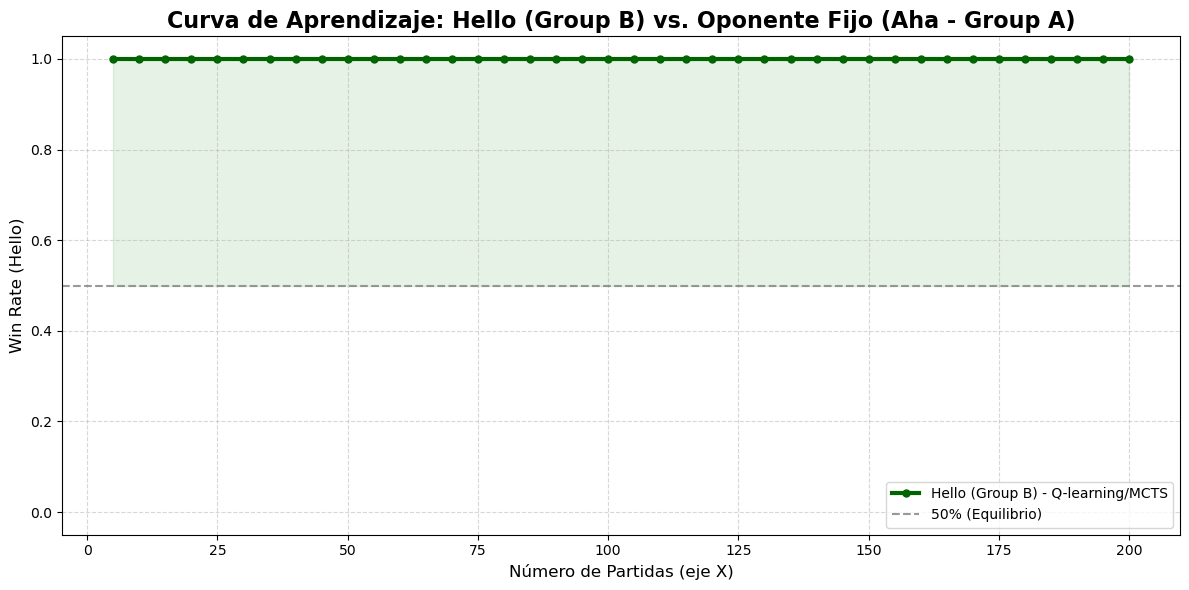


ANÁLISIS POR NIVELES DE APRENDIZAJE
Nivel 0 - Q-learning puro (partidas 1-1000000000):
  Victorias Hello: 200 de 200
  Win rate: 100.0%
Nivel 3 - Todo + MCTS (partidas 1-200):
  Victorias Hello: 200 de 200
  Win rate: 100.0%
✅ Análisis de fases completado.

✅ Modelo MCTS (Q-table) guardado exitosamente.

🎉 Simulación de curva de aprendizaje única finalizada.


In [80]:
# ============================================================
#  MAIN (Ejecución de la Simulación)
# ============================================================

# --- Parámetros de la Simulación ---
# Puedes ajustar estos valores según el tiempo que desees que dure la simulación.
NUM_PARTIDAS = 200
BATCH_SIZE = 5
AHA_DEPTH = 3       # Profundidad de búsqueda del agente oponente Aha

# --- Ejecución ---
print("Iniciando la simulación.")

# 1. Ejecutar la función de medición
# Esta función usará HelloMCTS, que fuerza la política MCTS.
hello, resultados, win_rates, epsilons, estados_q = medir_curva_unica(
    n_partidas=NUM_PARTIDAS,
    batch=BATCH_SIZE,
    aha_depth=AHA_DEPTH
)

# 2. Análisis de fases (usando la función que ya definiste)
# Los umbrales solo se usan para la impresión, pero el nivel interno de Hello
# debería ser 3 desde el inicio, dada la política forzada.
try:
    analizar_fases(
        resultados,
        umbral_victoria=hello.umbral_victoria,
        umbral_bloqueo=hello.umbral_bloqueo,
        umbral_mcts=hello.umbral_mcts
    )
    print("Análisis de fases completado.")
except NameError:
    print("ADVERTENCIA: La función 'analizar_fases' no está definida o no es accesible.")

# 3. Guardar el modelo (Recomendado para el Torneo)
if not hello.modo_torneo:
    # Guardamos el modelo MCTS/Q-learning aprendido
    # Nota: Si el archivo policyB_MCTS.py no tiene el método guardar_modelo, esto fallará.
    # Asumo que la clase Hello sí lo tiene.
    hello.guardar_modelo(filename="hello_champion_mcts_final.npz")
    print("\nModelo MCTS (Q-table) guardado exitosamente.")

print("\nSimulación de curva de aprendizaje única finalizada.")

## **IMPORTACIÓN Y USO DEL GRUPO C (OhYes)**

In [82]:
# Crear la estructura de directorios
os.makedirs("groups/GroupC", exist_ok=True)

In [90]:
import os
import shutil

src = os.path.join("connect4", "policy_GC.py")
dst = os.path.join("groups", "GroupC", "policy.py")

if os.path.exists(src):
    shutil.copy(src, dst)
    print("policy_GC.py copiado como groups/GroupC/policy.py")
else:
    print("No se encontró connect4/policy_GC.py")

✅ policy_GC.py copiado como groups/GroupC/policy.py


In [92]:
import importlib.util
import os

current_dir = os.getcwd()
GC_PATH = os.path.join(current_dir, "groups", "GroupC", "policy.py")

spec_gc = importlib.util.spec_from_file_location("GCModule", GC_PATH)
gc_module = importlib.util.module_from_spec(spec_gc)
spec_gc.loader.exec_module(gc_module)

# La clase dentro de policy_GC.py debe llamarse OhYes (según tu estructura original)
OhYes = gc_module.OhYes


In [94]:
print(OhYes)

<class 'GCModule.OhYes'>


In [107]:
# --- RUTA DEL OPONENTE (GroupA) ---
try:
    from groups.GroupA.policy import Aha
    print("Agente Oponente (Aha) cargado.")
except ImportError:
    from groups.GroupA.policy import Policy as Aha
    print("Agente Oponente (Policy as Aha) cargado.")
except Exception as e:
    print(f"ERROR al cargar el agente Aha: {e}")

# --- CARGA DINÁMICA DE AGENTE B ---
try:
    # Asumimos que la versión MCTS forzada está en groups/GroupB/policy.py
    spec_b = importlib.util.spec_from_file_location("module_b", "groups/GroupB/policy.py")
    module_b = importlib.util.module_from_spec(spec_b)
    sys.modules["module_b"] = module_b
    spec_b.loader.exec_module(module_b)
    HelloB = getattr(module_b, 'Hello')
    print("Agente Hello cargado.")
except Exception as e:
    print(f"ERROR al cargar el agente HelloB: {e}")

# --- CARGA DINÁMICA DE AGENTE C (Aprendizaje Progresivo) ---
try:
    spec_c = importlib.util.spec_from_file_location("module_c", "groups/GroupC/policy.py")
    module_c = importlib.util.module_from_spec(spec_c)
    sys.modules["module_c"] = module_c
    spec_c.loader.exec_module(module_c)
    PolicyC = getattr(module_c, 'OhYes')
    print("Agente OhYes cargado.")
except Exception as e:
    print(f"ERROR al cargar el agente PolicyC: {e}")

✅ Agente Oponente (Aha) cargado.
✅ Agente Hello cargado.
✅ Agente OhYes cargado.


In [96]:
import numpy as np
import matplotlib.pyplot as plt


def simular_y_aprender(AgenteClase, nombre_agente: str, OponenteClase, nombre_oponente: str, n_partidas: int = 200, batch: int = 5, depth: int = 3):
    """
    Simula el aprendizaje de un agente contra un oponente fijo (Aha).
    Devuelve la instancia entrenada, los datos de la curva y el WR final.
    """
    
    print("\n" + "="*60)
    print(f"INICIANDO EVALUACIÓN: {nombre_agente} vs {nombre_oponente}")
    print("="*60)
    
    agente = AgenteClase(modo_torneo=False) 
    # El oponente siempre se instancia fresco si es Aha
    oponente = OponenteClase(depth=depth) 
    
    resultados = []
    win_rates = []
    x_axis = []
    
    for i in range(n_partidas):
        # El agente que aprende juega contra el oponente fijo
        r = jugar_un_partido(agente, oponente) 
        resultados.append(r)

        if (i + 1) % batch == 0:
            ultimos = resultados[-batch:]
            wins_agente = ultimos.count(-1)
            winrate = wins_agente / len(ultimos)
            
            win_rates.append(winrate)
            x_axis.append(i + 1)
            
    total_wins_agente = resultados.count(-1)
    final_win_rate = total_wins_agente / n_partidas
    
    print(f"FINALIZADO. WR Final {nombre_agente}: {final_win_rate*100:.1f}%")
    
    return agente, win_rates, x_axis, final_win_rate

In [98]:
def simular_vs_oponente_entrenado(AgenteClase, nombre_agente: str, OponenteInstanciaFija,nombre_oponente:str, n_partidas: int = 100, batch: int = 5):
    """
    Simula el aprendizaje de un agente contra una instancia de oponente ya entrenada y fija.
    """
    
    print("\n" + "="*60)
    print(f"INICIANDO CURVA EXTRA: {nombre_agente} vs {nombre_oponente} (Fijo)")
    print("="*60)
    
    agente = AgenteClase(modo_torneo=False) 
    oponente = OponenteInstanciaFija # Usamos la instancia ya entrenada
    
    resultados = []
    win_rates = []
    x_axis = []
    
    for i in range(n_partidas):
        # El agente que aprende juega contra el oponente fijo
        r = jugar_un_partido(agente, oponente) 
        resultados.append(r)

        if (i + 1) % batch == 0:
            ultimos = resultados[-batch:]
            wins_agente = ultimos.count(-1)
            winrate = wins_agente / len(ultimos)
            
            win_rates.append(winrate)
            x_axis.append(i + 1)
            
    final_win_rate = resultados.count(-1) / n_partidas
    
    print(f"FINALIZADO. WR Final {nombre_agente}: {final_win_rate*100:.1f}%")
    
    return win_rates, x_axis, final_win_rate

In [101]:
def graficar_comparacion(wr_B, x_axis_B, final_wr_B, 
                         wr_C, x_axis_C, final_wr_C,
                         wr_C_vs_B=None, x_axis_C_vs_B=None, final_wr_C_vs_B=None):
    
    plt.figure(figsize=(12, 7))
    
    # Curva 1: Hello (B) vs Aha (A)
    plt.plot(x_axis_B, wr_B, marker='o', linestyle='-', 
             label=f"Hello (B) vs Aha - WR Final: {final_wr_B:.2f}", color='#006400')
    
    # Curva 2: OhYes (C) vs Aha (A)
    plt.plot(x_axis_C, wr_C, marker='x', linestyle='--', 
             label=f"OhYes (C) vs Aha - WR Final: {final_wr_C:.2f}", color='#FF8C00')
    
    # Curva 3: OhYes (C) vs Hello (B)
    if wr_C_vs_B is not None:
        plt.plot(x_axis_C_vs_B, wr_C_vs_B, marker='s', linestyle=':', 
                 label=f"OhYes (C) vs Hello (B) - WR Final: {final_wr_C_vs_B:.2f}", color='#1E90FF')
    
    # Líneas de Referencia y Configuración
    plt.axhline(y=0.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.7, label="50% (Equilibrio)")
    plt.axhline(y=0.95, color='darkred', linestyle='-.', linewidth=1.0, alpha=0.7, label="Robustez (95%)")

    plt.title("COMPARACIÓN DE CURVAS DE APRENDIZAJE DE AGENTES", fontsize=16, fontweight='bold')
    plt.xlabel("Número de Partidas", fontsize=12)
    plt.ylabel("Win Rate (Tasa de Victoria)", fontsize=12)
    plt.ylim(0.0, 1.05)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

    print("\nComparación de agentes B y C completada.")


INICIANDO EVALUACIÓN: Hello (B) vs Aha (A)
✅ FINALIZADO. WR Final Hello (B): 47.0%

INICIANDO EVALUACIÓN: OhYes (C) vs Aha (A)
✅ FINALIZADO. WR Final OhYes (C): 44.0%

INICIANDO CURVA EXTRA: OhYes (C) vs Hello (B) (Fijo)
✅ FINALIZADO. WR Final OhYes (C): 9.0%


C:\Users\andis\AppData\Local\Temp\ipykernel_32708\682406109.py:30: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\andis\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


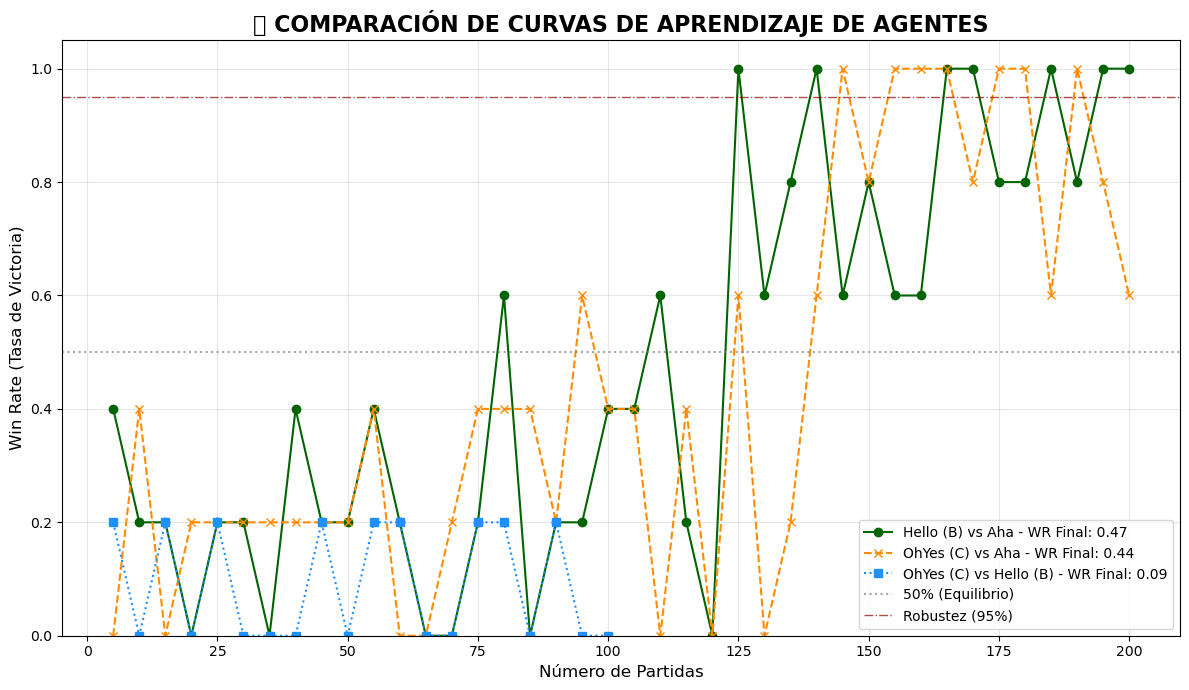


🎉 Comparación de agentes B y C completada.


In [109]:
# ============================================================
#  MAIN: EJECUTAR LAS 3 SIMULACIONES Y COMPARAR
# ============================================================

NUM_PARTIDAS = 200 
BATCH_SIZE = 5 
AHA_DEPTH = 3 

# --- 1. EVALUAR AGENTE B (Hello vs Aha) ---
try:
   # Capturamos la instancia entrenada (agente_B_entrenado)
    agente_B_entrenado, wr_B, x_axis_B, final_wr_B = simular_y_aprender(
        HelloB, "Hello (B)", Aha, "Aha (A)", 
        n_partidas=NUM_PARTIDAS, batch=BATCH_SIZE, depth=AHA_DEPTH
    )
except NameError:
  print("ERROR: HelloB o Aha no definidos.")
  wr_B, x_axis_B, final_wr_B, agente_B_entrenado = None, None, None, None


# --- 2. EVALUAR AGENTE C (OhYes vs Aha) ---
try:
   _, wr_C, x_axis_C, final_wr_C = simular_y_aprender(
       PolicyC, "OhYes (C)", Aha, "Aha (A)", 
       n_partidas=NUM_PARTIDAS, batch=BATCH_SIZE, depth=AHA_DEPTH
    )
except NameError:
  print("ERROR: PolicyC o Aha no definidos.")
  wr_C, x_axis_C, final_wr_C = None, None, None

# --- 3. EVALUAR CURVA EXTRA: OHYES (C) vs HELLO ENTRENADO (B) ---
wr_C_vs_B, x_axis_C_vs_B, final_wr_C_vs_B = None, None, None

if agente_B_entrenado is not None and wr_C is not None:
    # MUY IMPORTANTE: Asegurar que HelloB no aprenda en esta simulación
    agente_B_entrenado.epsilon = 0.0
    agente_B_entrenado.modo_torneo = True
    
    wr_C_vs_B, x_axis_C_vs_B, final_wr_C_vs_B = simular_vs_oponente_entrenado(
        PolicyC, 
        "OhYes (C)", 
        agente_B_entrenado, # Oponente fijo y entrenado
        "Hello (B)",
        n_partidas=100, # Menos partidas para el enfrentamiento directo
        batch=BATCH_SIZE
    )


# --- 4. GRÁFICA DE COMPARACIÓN FINAL ---
if wr_B is not None and wr_C is not None:
   graficar_comparacion(
        wr_B, x_axis_B, final_wr_B, 
        wr_C, x_axis_C, final_wr_C,
        wr_C_vs_B, x_axis_C_vs_B, final_wr_C_vs_B
        )
else:
    print("\n No se puede generar la gráfica de comparación. Verifica si HelloB y PolicyC se cargaron correctamente.")

## **USO DEL NUEVO HELLO DESPUES DE ALGUNOS AJUSTES DE GRADESCOPE**

In [123]:
import importlib.util
import os
import sys

# --- NUEVO NOMBRE DE VARIABLE ---
NEW_HELLO_PATH = os.path.join(os.getcwd(), "connect4", "policy_HELLO.py")

print("Intentando cargar el nuevo Hello desde:", NEW_HELLO_PATH)

try:
    # Crear el spec del módulo
    spec_hello = importlib.util.spec_from_file_location("policy_hello_module", NEW_HELLO_PATH)
    hello_module = importlib.util.module_from_spec(spec_hello)

    # Registrar el módulo
    sys.modules["policy_hello_module"] = hello_module

    # Ejecutar el módulo
    spec_hello.loader.exec_module(hello_module)

    # Obtener la clase Hello
    Hello = getattr(hello_module, "Hello")

    print("Hello cargado correctamente desde policy_HELLO.py")

except Exception as e:
    print(f"ERROR al cargar Hello desde policy_HELLO.py:\n{e}")


Intentando cargar el nuevo Hello desde: C:\Users\andis\PROYECTO_FINAL_CONNECT4\connect4\policy_HELLO.py
✅ Hello cargado correctamente desde policy_HELLO.py


In [115]:
try:
    h = Hello()
    print("Instancia creada correctamente:", h)
except Exception as e:
    print("Error creando instancia de Hello:", e)

Instancia creada correctamente: <policy_hello_module.Hello object at 0x0000026FC47ADAF0>


In [125]:
# ============================================================
#  FUNCIÓN: MEDIR LA CURVA DE APRENDIZAJE (HELLO vs AHA)
# ============================================================

def medir_curva_unica(n_partidas: int = 200, batch: int = 5, aha_depth: int = 3):
    """
    Juega n_partidas y genera un único gráfico enfocado en el Win Rate
    y la robustez del agente Hello (Group B) contra Aha (Group A).
    """
    print("="*60)
    print("INICIANDO EVALUACIÓN DE CURVA DE APRENDIZAJE (Gráfico Único)")
    print("="*60)
    print(f"Total de partidas: {n_partidas}")
    print(f"Agente Hello Actualizado (GB): Q-learning + MCTS (con aprendizaje)")
    print(f"Agente Aha (GA): Minimax (Profundidad={aha_depth}) [Línea Base]")
    print("="*60)

    # ------------------ Lógica de Simulación ------------------
    # Instancia el agente Hello para que aprenda (modo_torneo=False)
    hello = Hello(modo_torneo=False)

    hello.umbral_victoria = 80
    hello.umbral_bloqueo = 120
    hello.umbral_mcts = 160
    
    # Instancia el oponente fijo Aha
    aha = Aha(depth=aha_depth)

    resultados = []
    win_rates = []
    epsilons = []
    estados_q = []
    x_axis = []
    niveles = ["Q-learning", "Q + Victoria", "Q + Bloqueo", "Q + MCTS"] # Asumimos 4 niveles

    for i in range(n_partidas):
        r = jugar_un_partido(hello, aha) 
        resultados.append(r)

        if (i + 1) % batch == 0:
            ultimos = resultados[-batch:]
            wins_hello = ultimos.count(-1)
            winrate = wins_hello / len(ultimos)

            win_rates.append(winrate)
            epsilons.append(hello.epsilon)
            estados_q.append(len(hello.Q))
            x_axis.append(i + 1)

            nivel_nombre = niveles[hello.nivel_actual] if hello.nivel_actual < len(niveles) else niveles[len(niveles)-1]

            print(f"Partidas {i+1:3d}: WinRate={winrate:.2f} | "
                  f"Epsilon={hello.epsilon:.3f} | "
                  f"Nivel={hello.nivel_actual} ({nivel_nombre})")

    # ------------------ ESTADÍSTICAS FINALES ------------------
    total_wins_hello = resultados.count(-1)
    final_wr = total_wins_hello/n_partidas
    
    print("\n" + "="*60)
    print("ESTADÍSTICAS FINALES")
    print("="*60)
    print(f"Win Rate Final Hello: {final_wr*100:.1f}%")
    print(f"Estados en Q-table: {len(hello.Q)}")
    print("="*60)


    # ===== GRAFICAR: CURVA DE APRENDIZAJE ÚNICA =====

    plt.figure(figsize=(12, 6))

    # --- Curva de Aprendizaje de Hello (Group B) ---
    plt.plot(x_axis, win_rates, marker='o', color='#006400',
             linewidth=3, markersize=5, label=f"Hello (Group B) vs Aha - WR Final: {final_wr:.2f}")

    # --- Línea Base de Equilibrio ---
    plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1.5, alpha=0.8, label="50% (Equilibrio)")
    # Línea de Robustez Alta
    plt.axhline(y=0.95, color='darkred', linestyle='-.', linewidth=1.0, alpha=0.7, label="Robustez Meta (95%)")

    # --- Marcar Fases de Habilidad (Umbrales) ---
    if hasattr(hello, 'umbral_mcts'):
        umbrales = [hello.umbral_victoria, hello.umbral_bloqueo, hello.umbral_mcts]
        colores = ['orange', 'purple', 'red']
        labels = ["Victoria activada", "Bloqueo activado", "MCTS activado"]

        for umbral, color, label in zip(umbrales, colores, labels):
            if umbral <= n_partidas and umbral > 0:
                idx = next((i for i, x in enumerate(x_axis) if x >= umbral), None)

                if idx is not None:
                    plt.axvline(x=umbral, color=color, linestyle=':',
                                linewidth=1.5, alpha=0.7, label=f"{label} ({umbral})")

                    plt.annotate(label.split()[0],
                                 (umbral, win_rates[idx]),
                                 textcoords="offset points",
                                 xytext=(0, 10),
                                 ha='center',
                                 fontsize=9,
                                 color=color)

    # --- Configuración Visual Final ---
    plt.title("Curva de Aprendizaje: Hello (Group B) vs. Oponente Fijo (Aha - Group A)",
              fontsize=16, fontweight='bold')
    plt.xlabel(f"Número de Partidas (eje X)", fontsize=12)
    plt.ylabel("Win Rate (Hello)", fontsize=12)
    plt.ylim(-0.05, 1.05)
    plt.grid(True, alpha=0.5, linestyle='--')
    plt.legend(loc='lower right', fontsize=10)

    # Sombreado de Ventaja
    plt.fill_between(x_axis, win_rates, 0.5,
                     where=(np.array(win_rates) > 0.5),
                     color='green', alpha=0.1, label="Ventaja (Hello)")

    plt.tight_layout()
    plt.show()

    return hello, resultados, win_rates, epsilons, estados_q

🚨 Iniciando la simulación. 🚨
INICIANDO EVALUACIÓN DE CURVA DE APRENDIZAJE (Gráfico Único)
Total de partidas: 200
Agente Hello Actualizado (GB): Q-learning + MCTS (con aprendizaje)
Agente Aha (GA): Minimax (Profundidad=3) [Línea Base]
Partidas   5: WinRate=0.00 | Epsilon=0.965 | Nivel=0 (Q-learning)
Partidas  10: WinRate=0.20 | Epsilon=0.942 | Nivel=0 (Q-learning)
Partidas  15: WinRate=0.60 | Epsilon=0.918 | Nivel=0 (Q-learning)
Partidas  20: WinRate=0.40 | Epsilon=0.896 | Nivel=0 (Q-learning)
Partidas  25: WinRate=0.20 | Epsilon=0.873 | Nivel=0 (Q-learning)
Partidas  30: WinRate=0.00 | Epsilon=0.852 | Nivel=0 (Q-learning)
Partidas  35: WinRate=0.40 | Epsilon=0.831 | Nivel=0 (Q-learning)
Partidas  40: WinRate=1.00 | Epsilon=0.810 | Nivel=0 (Q-learning)
Partidas  45: WinRate=0.20 | Epsilon=0.790 | Nivel=0 (Q-learning)
Partidas  50: WinRate=0.20 | Epsilon=0.771 | Nivel=0 (Q-learning)
Partidas  55: WinRate=0.20 | Epsilon=0.751 | Nivel=0 (Q-learning)
Partidas  60: WinRate=0.00 | Epsilon=0.7

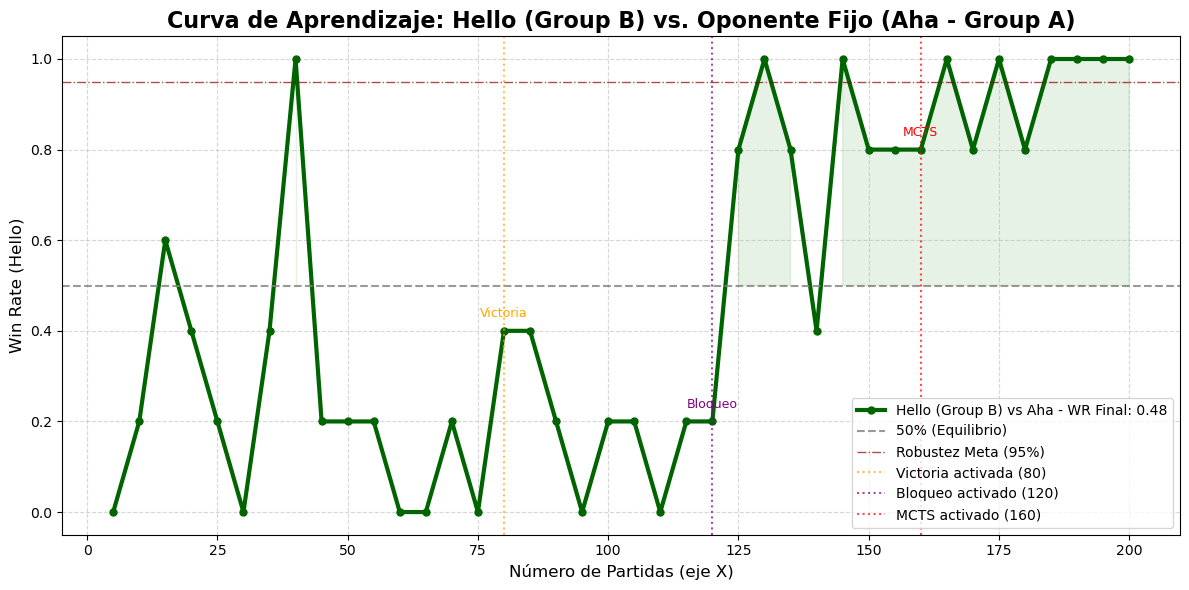


ANÁLISIS POR NIVELES DE APRENDIZAJE
Nivel 0 - Q-learning puro (partidas 1-80):
  Victorias Hello: 20 de 80
  Win rate: 25.0%
Nivel 1 - Q + Victoria (partidas 81-120):
  Victorias Hello: 7 de 40
  Win rate: 17.5%
Nivel 2 - Q + Victoria + Bloqueo (partidas 121-160):
  Victorias Hello: 32 de 40
  Win rate: 80.0%
Nivel 3 - Todo + MCTS (partidas 161-200):
  Victorias Hello: 38 de 40
  Win rate: 95.0%

✅ Gráfico de curva de aprendizaje único generado exitosamente.


In [127]:
# ============================================================
#  MAIN: EJECUTAR LA SIMULACIÓN ÚNICA
# ============================================================

if __name__ == "__main__":

    # Parámetros
    NUM_PARTIDAS = 200
    BATCH_SIZE = 5
    AHA_DEPTH = 3

    print("Iniciando la simulación.")

    try:
        # 1. Ejecutar la función de medición
        hello, resultados, win_rates, epsilons, estados_q = medir_curva_unica(
            n_partidas=NUM_PARTIDAS,
            batch=BATCH_SIZE,
            aha_depth=AHA_DEPTH
        )

        # 2. Análisis de fases
        if 'analizar_fases' in globals() and hasattr(hello, 'umbral_mcts'):
            analizar_fases(
                resultados,
                umbral_victoria=hello.umbral_victoria,
                umbral_bloqueo=hello.umbral_bloqueo,
                umbral_mcts=hello.umbral_mcts
            )

        print("\n Gráfico de curva de aprendizaje único generado exitosamente.")
        
    except Exception as e:
        print(f"\n Falla grave en la ejecución del MAIN: {e}")
        print("Asegúrate de que las clases Hello y Aha, y las funciones jugar_un_partido y analizar_fases estén definidas correctamente.")